# NSSP Projet 2

## PART 3 : Regression for joint angles

### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter, sosfiltfilt, welch
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from matplotlib.patches import Rectangle

### Load subject 1

In [2]:
data = loadmat("S1_E1_A1.mat")
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


### 1 Visualize, preprocess and split the data

In [3]:
emg = data["emg"]
print("EMG data dimension: {}".format(emg.shape))
print("EMG data type: {}".format(type(emg)))

stimulus = data["restimulus"] 
repetition = data["rerepetition"] 

print("Stimuli {} , Repetitions {}".format(stimulus.shape,repetition.shape))

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg.shape[1]

print(f'Number of movements : {n_stimuli}') 
print(f'Number of repetitions : {n_repetitions}') 

EMG data dimension: (2292526, 16)
EMG data type: <class 'numpy.ndarray'>
Stimuli (2292526, 1) , Repetitions (2292526, 1)
Number of movements : 9
Number of repetitions : 10


In [4]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

print("Number of sample per trials \n Mean : {} \n std : {} \n min : {} \n max: {}".format(number_of_samples_per_trial.mean(),number_of_samples_per_trial.std(),number_of_samples_per_trial.min(),number_of_samples_per_trial.max()))

Number of sample per trials 
 Mean : 12270.566666666668 
 std : 3680.100780775802 
 min : 5667.0 
 max: 20935.0


#### Visualize signals

/var/folders/3s/zlrwdymn79q5z4m7dgq_nk440000gn/T/ipykernel_60352/660796205.py:12: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


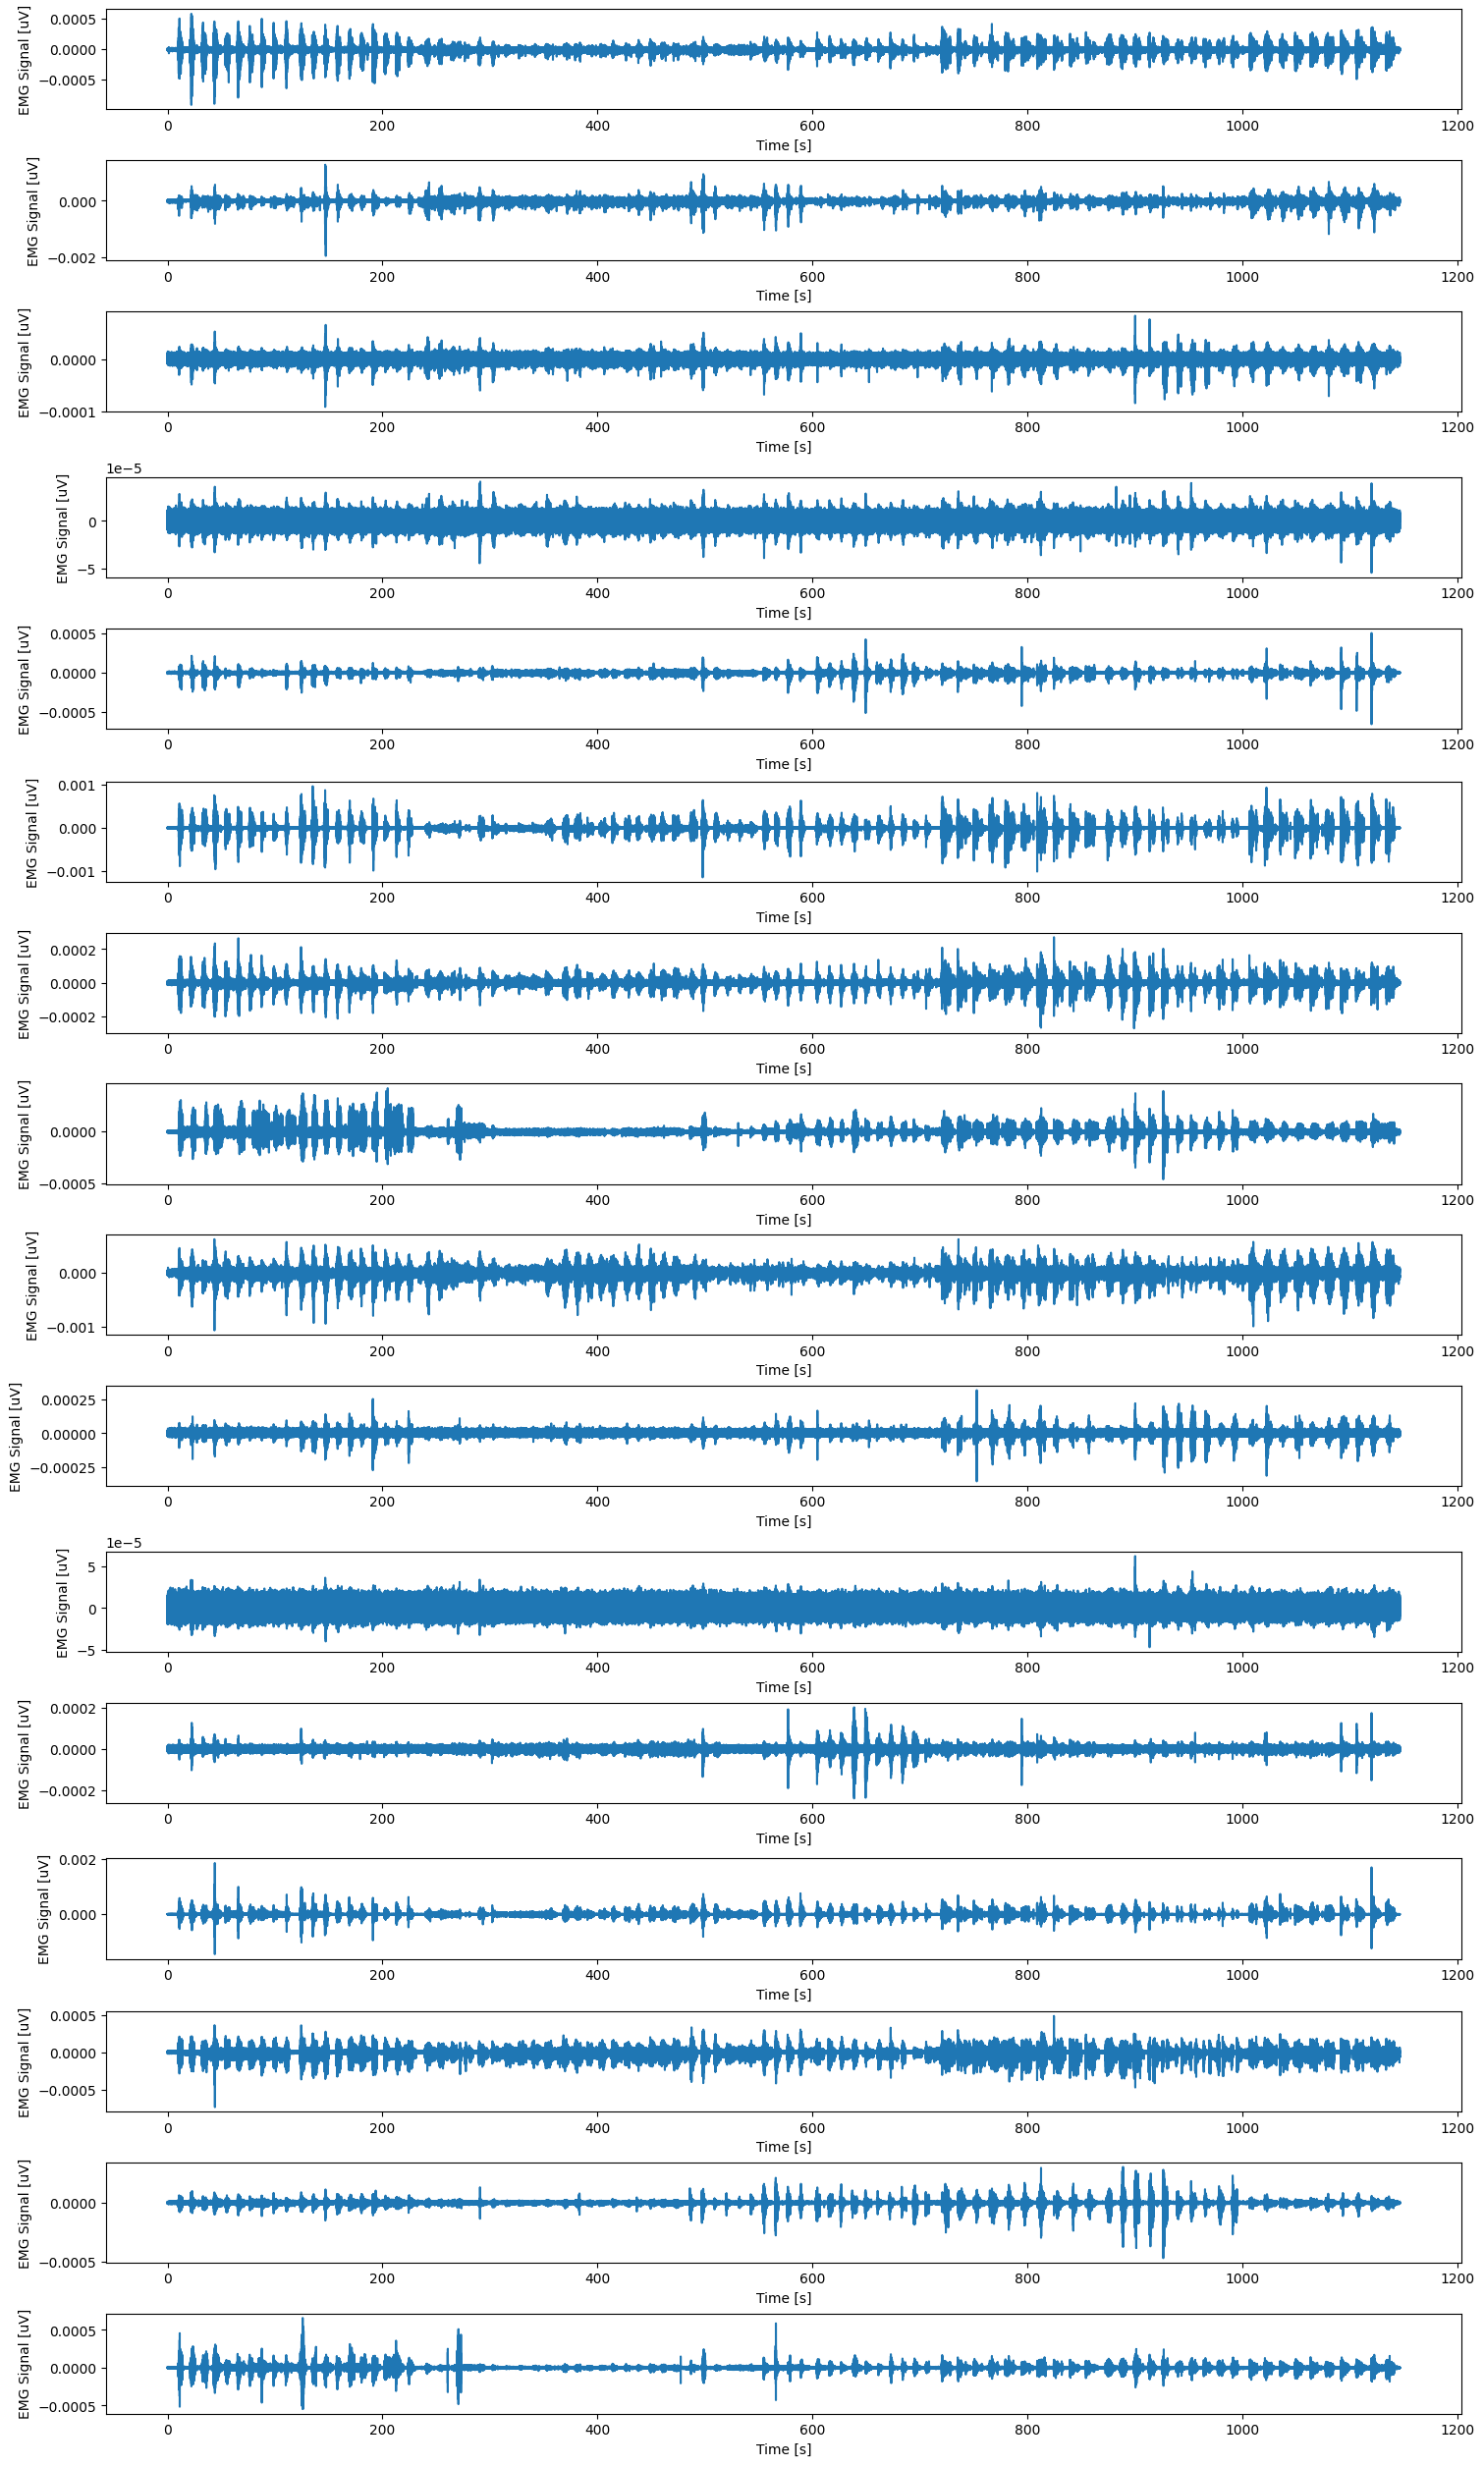

In [28]:
n_channels = emg.shape[1]
fs = 2000
time_steps = np.arange(0,emg.shape[0]/fs, 1/fs) 

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 25))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [uV]")

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.5)
plt.savefig('plots/EMG_raw.png')

#### Preprocessing

In [6]:
# apply bandpass filter
bandpass_cutoff_frequencies_Hz = (5, 500) 
sos = butter(N=4, Wn=bandpass_cutoff_frequencies_Hz, fs=fs, btype="bandpass", output="sos") 
emg_filtered = sosfiltfilt(sos, emg.T).T 

powergrid_noise_frequencies_Hz = [harmonic_idx*50 for harmonic_idx in range(1,3)] # removing 50Hz noise and its harmonics

for noise_frequency in powergrid_noise_frequencies_Hz:
    sos = butter(N=4, Wn=(noise_frequency - 2, noise_frequency + 2), fs=fs, btype="bandstop", output="sos")
    emg_filtered = sosfiltfilt(sos, emg_filtered.T).T

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

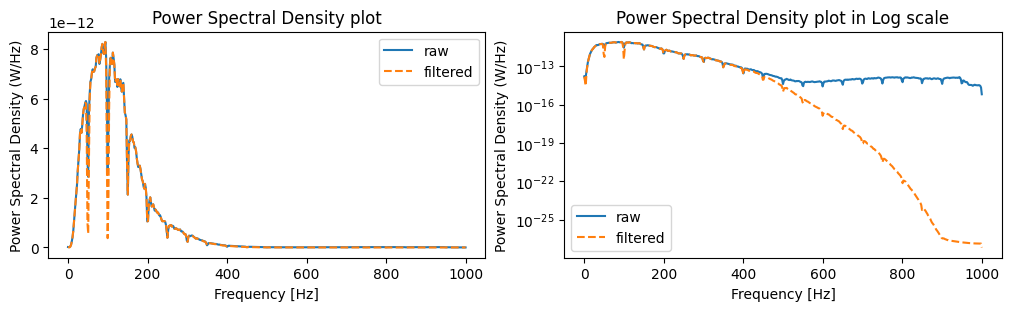

In [7]:
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg[:, 0], fs=fs, nperseg=1064)
freqs_post, Pxx_post = welch(emg_filtered[:, 0],fs = fs,  nperseg=1064)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].plot(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].semilogy(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

/var/folders/3s/zlrwdymn79q5z4m7dgq_nk440000gn/T/ipykernel_60352/2296132638.py:11: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


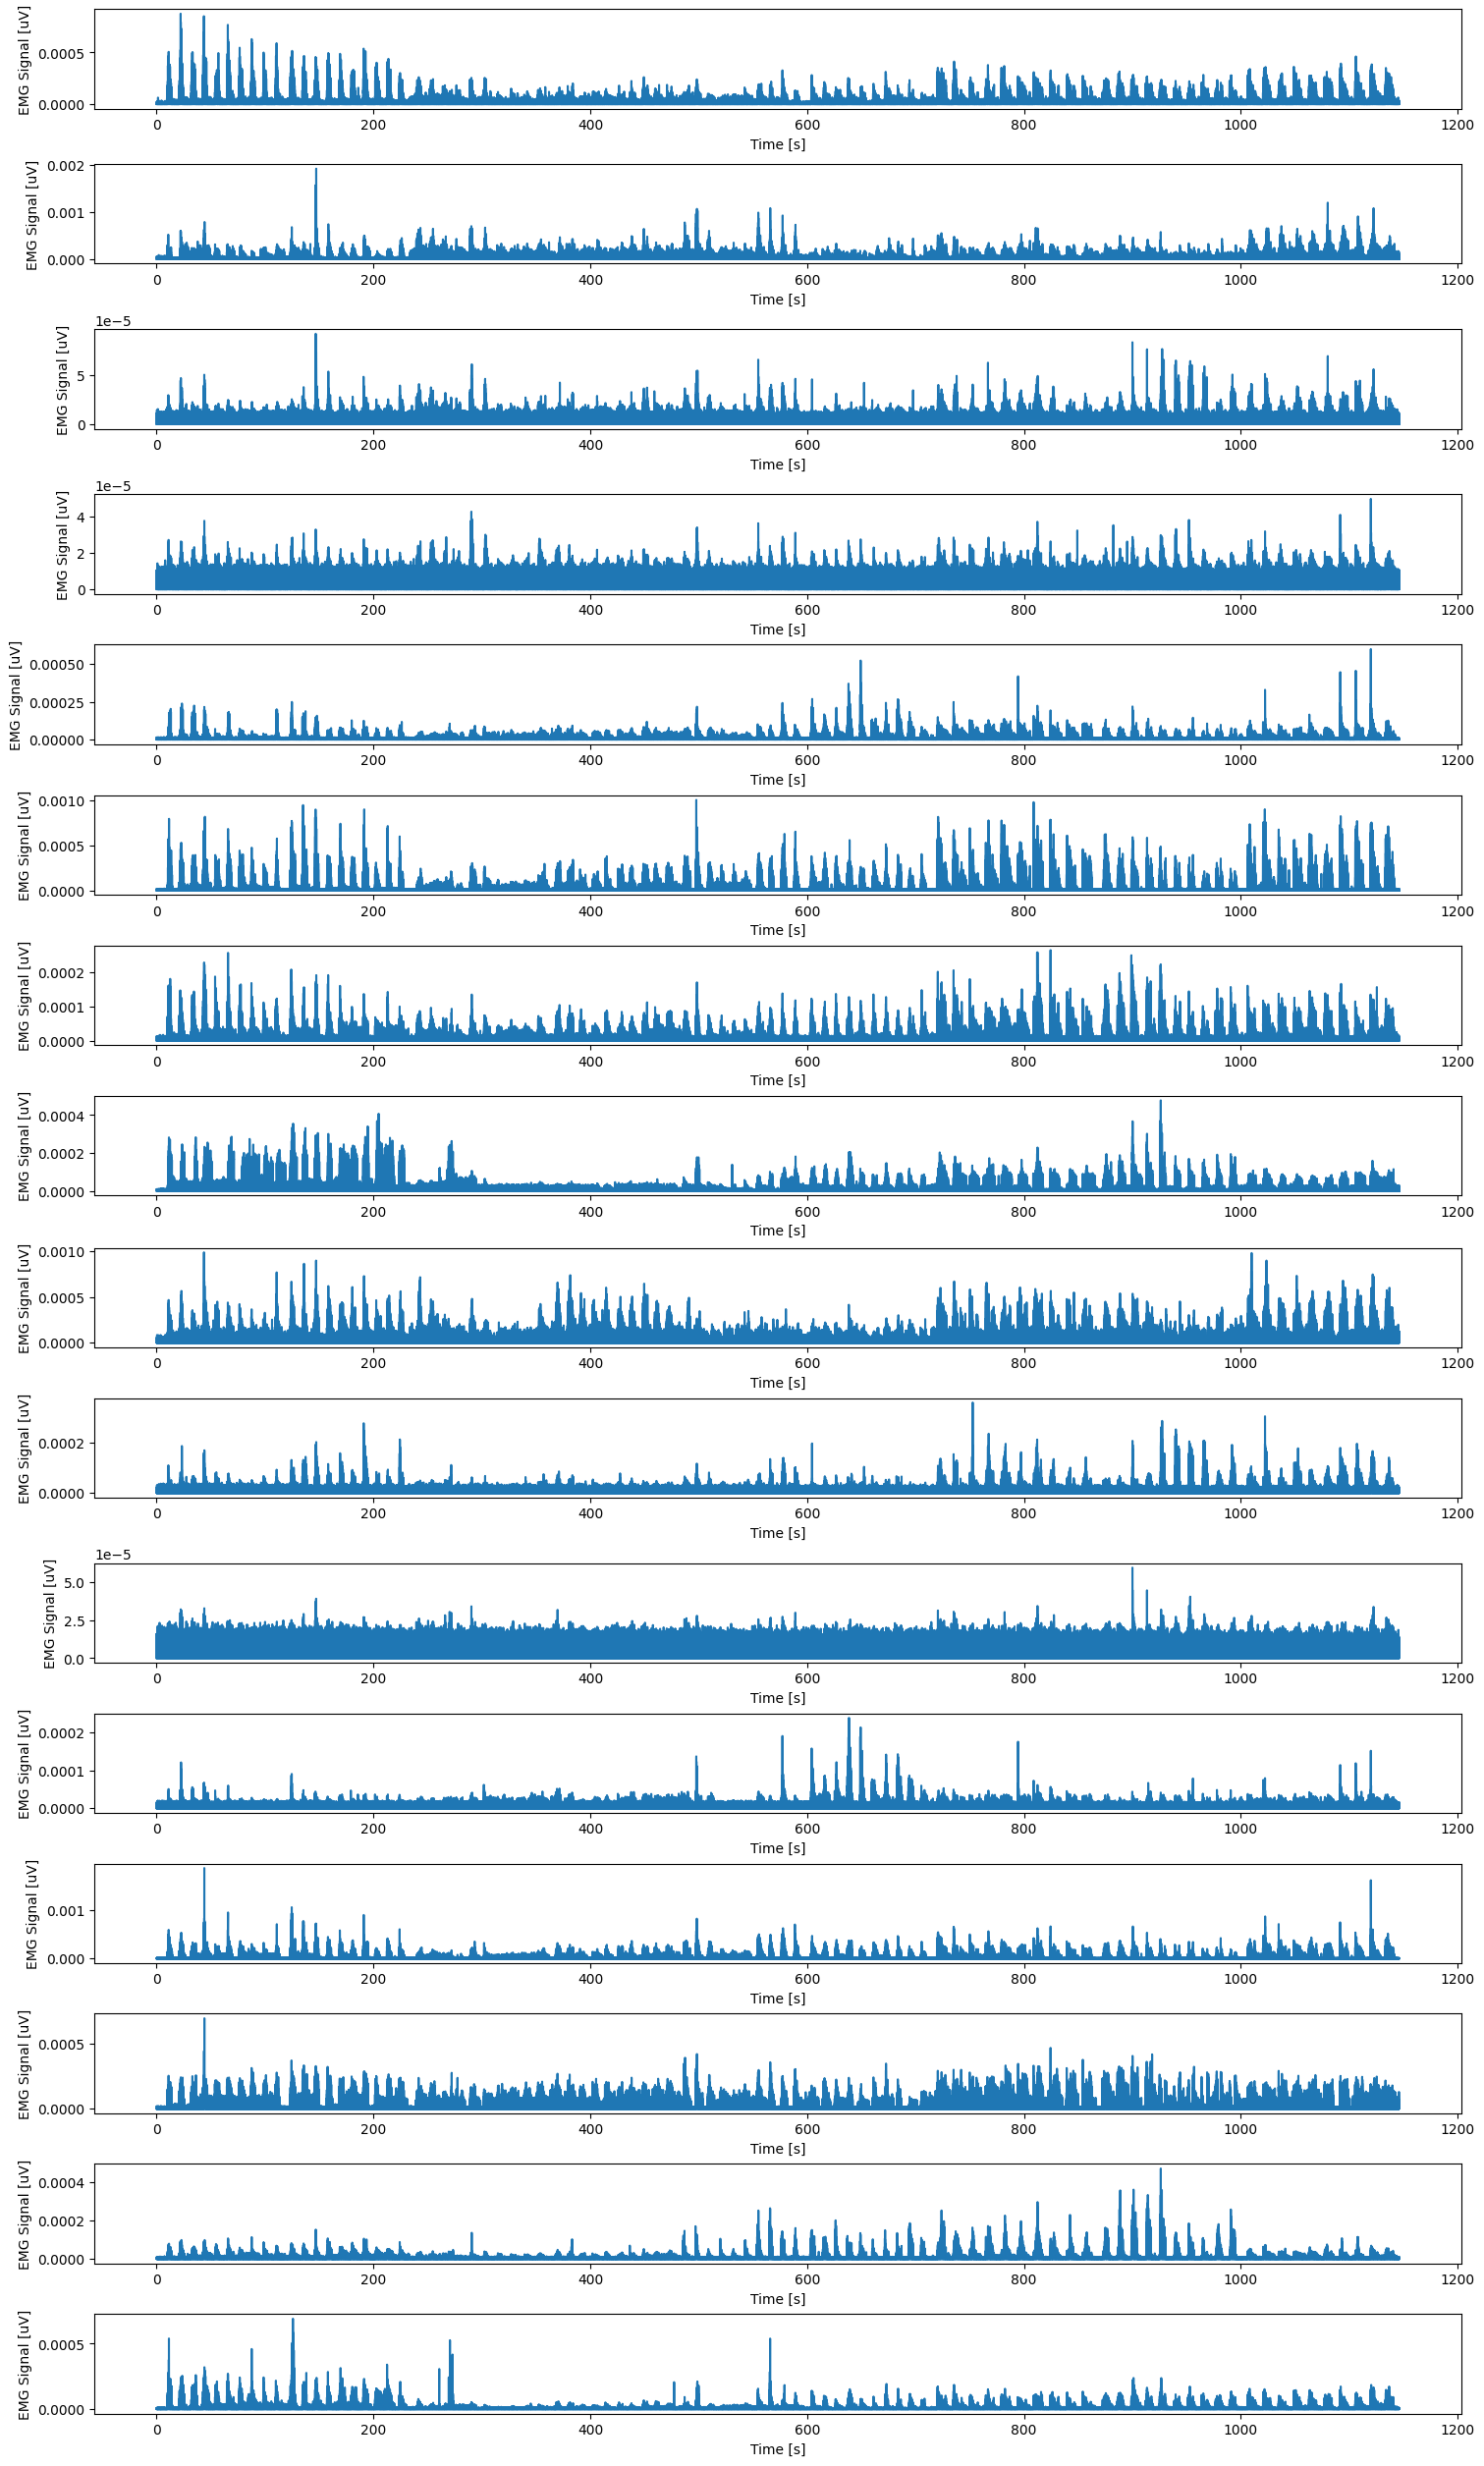

In [8]:
# Rectify signals
emg_rectified = np.abs(emg_filtered)

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 25))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_rectified[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [uV]")

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.5)

In [9]:
glove_data_index = data["glove"]
print("Glove data dimension: {}".format(glove_data_index.shape))
print("Glove data type: {}".format(type(glove_data_index)))

Glove data dimension: (2292526, 18)
Glove data type: <class 'numpy.ndarray'>


EMG envelopes dimension: (2292526, 16)


/var/folders/3s/zlrwdymn79q5z4m7dgq_nk440000gn/T/ipykernel_60352/2155087311.py:13: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


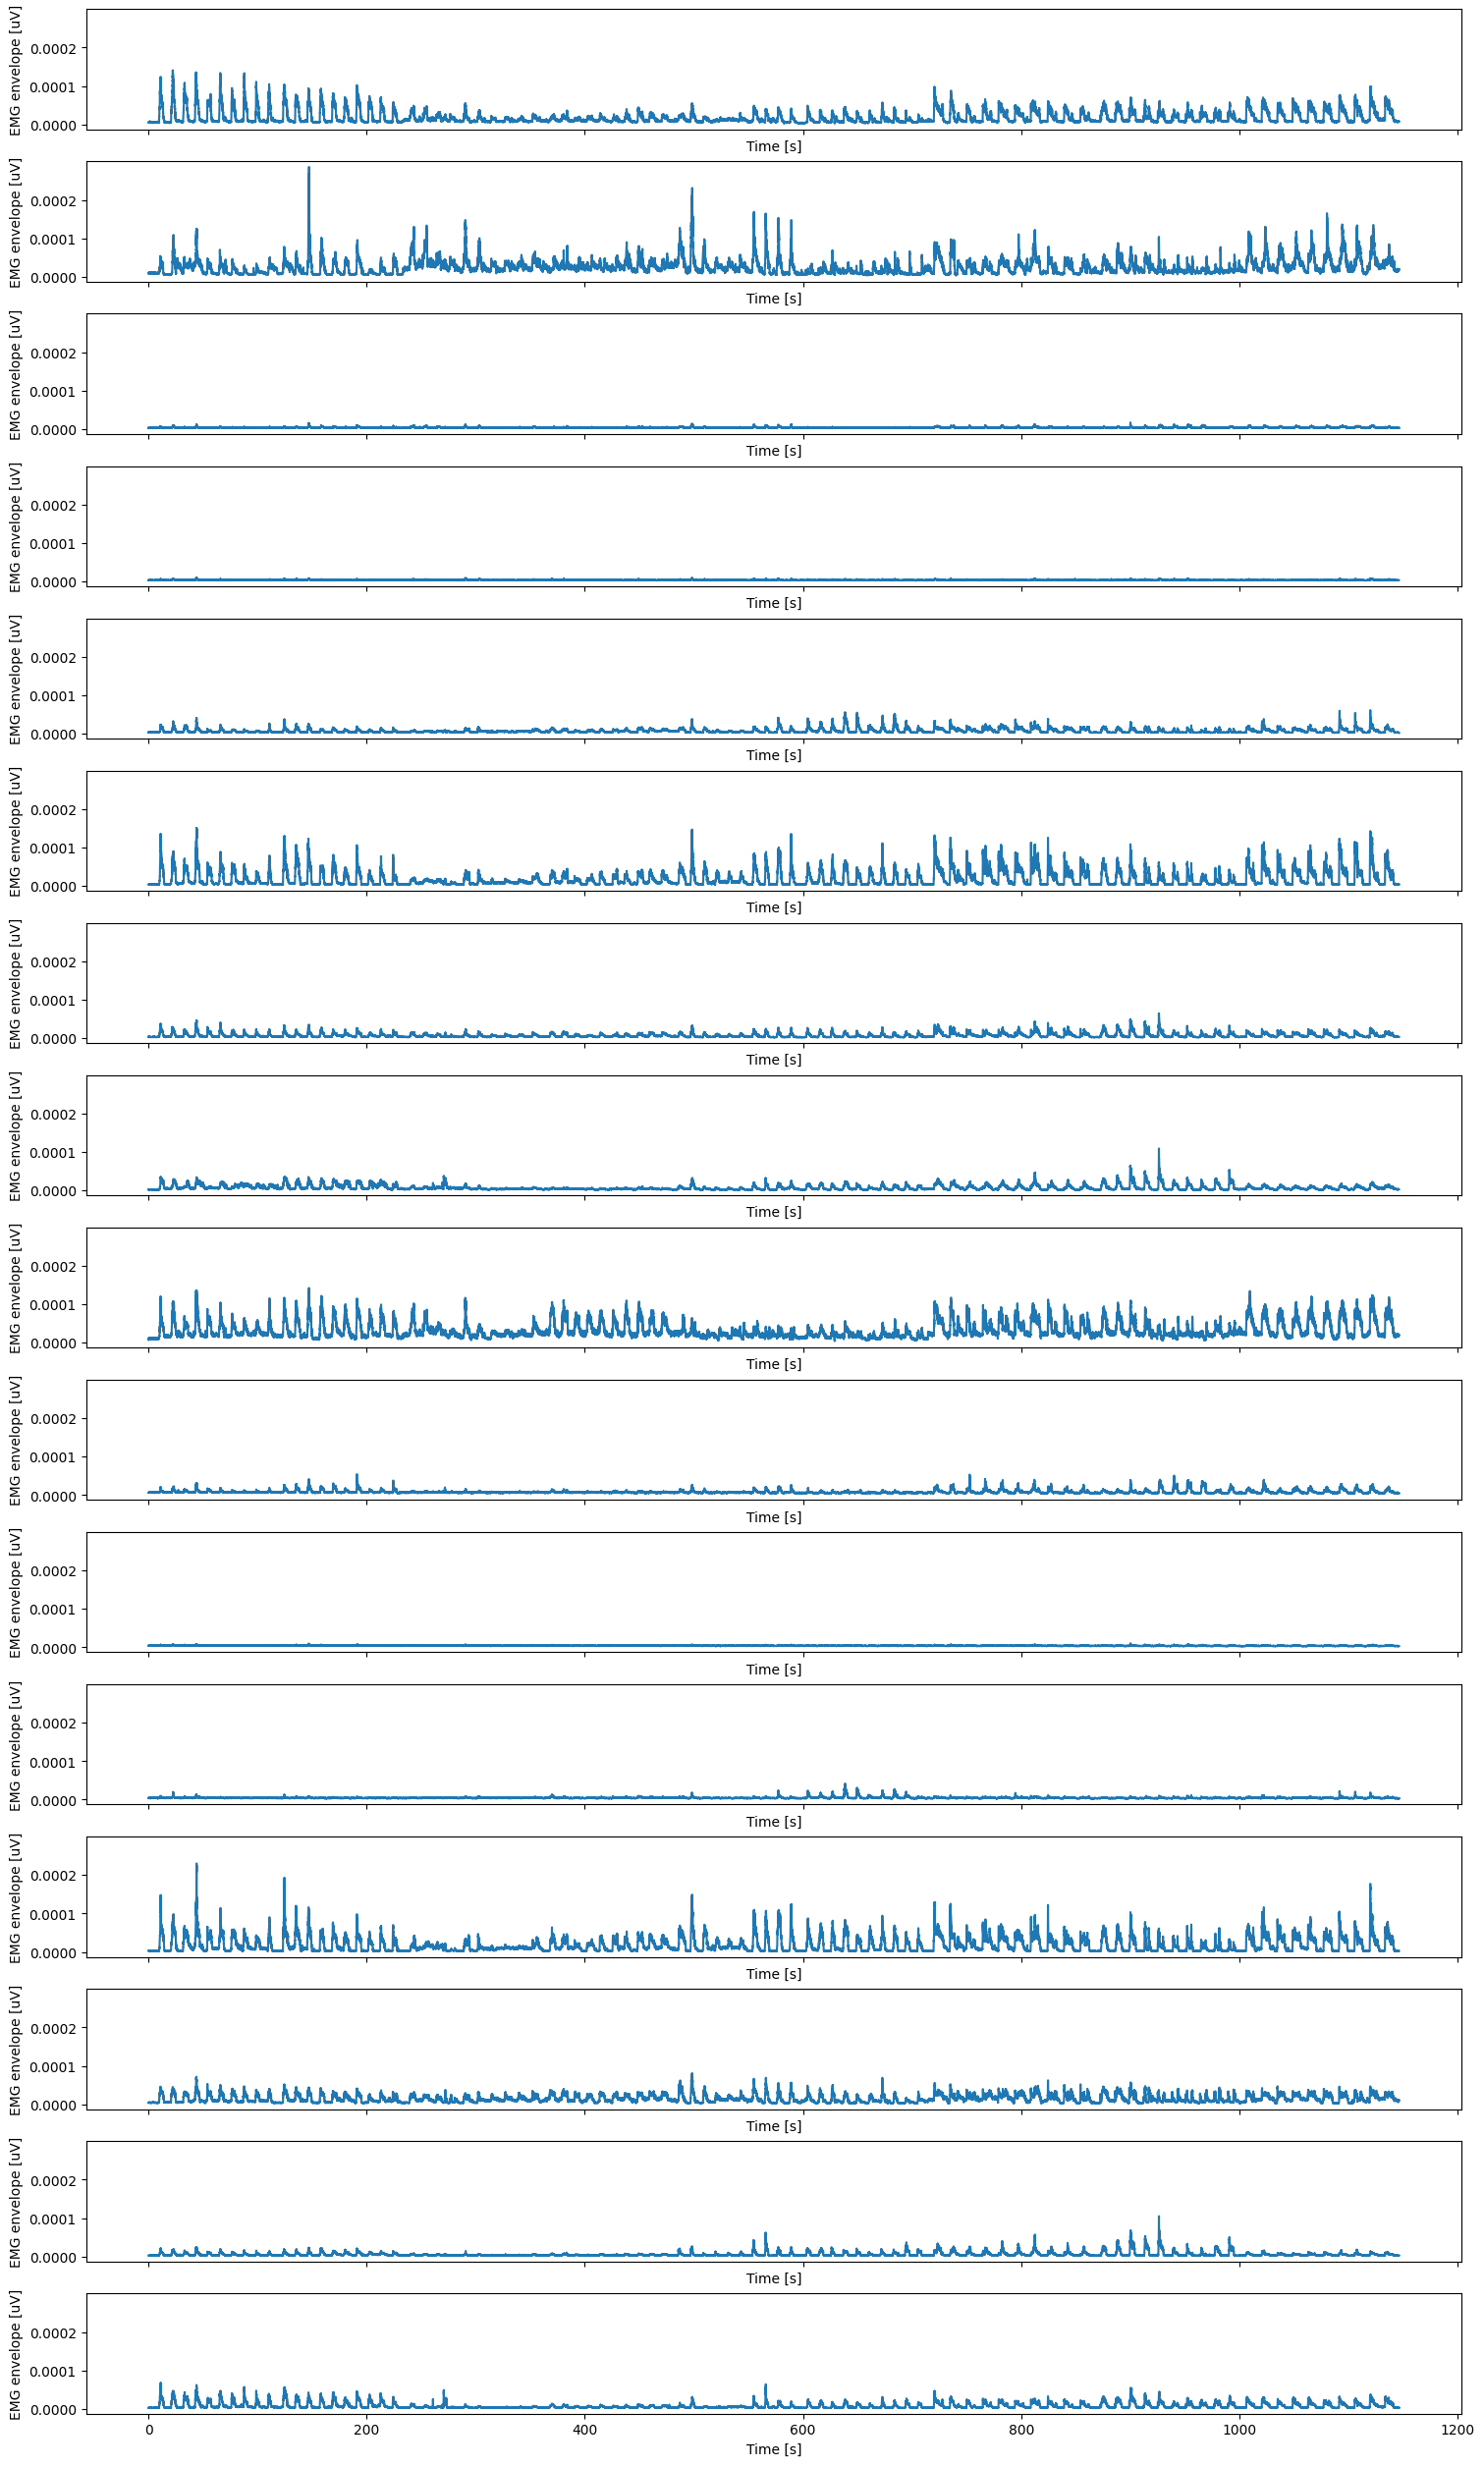

In [29]:
mov_mean_length = 400
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length
emg_envelopes = convolve1d(emg_rectified, weights=mov_mean_weights, axis=0) 
print("EMG envelopes dimension: {}".format(emg_envelopes.shape))

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 25), sharex=True, sharey=True)
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_envelopes[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG envelope [uV]")

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.5)
plt.savefig('plots/EMG_envelop.png')

### 2 Perform sliding window

In [11]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

In [12]:
# only regressing on finger joint 3,6,8,11 and 14
glove_data_index = data["glove"][:, [3,6,8,11,14]]
emg_window_length_sec = 128e-3  # [s]
incremental_window_length_sec = 50e-3  # [s]
repetition = data["repetition"].flatten()

print("Repetitions {}".format(repetition.shape))

Repetitions (2292526,)


In [13]:
# Split data by repetitions for training and testing
train_reps = [1, 2, 3, 4, 7, 8, 9, 10]
test_reps = [5, 6]

train_indices = np.isin(repetition, train_reps) #booleen
test_indices = np.isin(repetition, test_reps) #booleen

# Extract training and testing data
emg_train = emg_envelopes[train_indices, :]
glove_train = glove_data_index[train_indices, :]

emg_test = emg_envelopes[test_indices, :]
glove_test = glove_data_index[test_indices, :]

In [14]:
# Extract time windows for training and testing
EMG_train_windows, Labels_train_windows = extract_time_windows_regression(emg_train, glove_train, fs, emg_window_length_sec, incremental_window_length_sec)

EMG_test_windows, Labels_test_windows = extract_time_windows_regression(emg_test, glove_test, fs, emg_window_length_sec, incremental_window_length_sec)

# Print shapes to verify
print(f"EMG_train_windows shape: {EMG_train_windows.shape}")
print(f"Labels_train_windows shape: {Labels_train_windows.shape}")
print(f"EMG_test_windows shape: {EMG_test_windows.shape}")
print(f"Labels_test_windows shape: {Labels_test_windows.shape}")


EMG_train_windows shape: (11955, 256, 16)
Labels_train_windows shape: (11955, 256, 5)
EMG_test_windows shape: (3001, 256, 16)
Labels_test_windows shape: (3001, 256, 5)


### 3 Extract set of features 

In [15]:
# in paper : wilson amplitude, 4e order auto regressive coeffs, waveform length, log-variance, slope sign change
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean and standard deviation of each window and the mean of the labels window
    """
    EMG_wilson_amp = np.ptp(EMG_windows, axis=1)
    print("Wilson Amplitude shape:", EMG_wilson_amp.shape)
    
    EMG_wave_length = np.sum(np.abs(np.diff(EMG_windows, axis=1)), axis=1)
    print("Waveform Length shape:", EMG_wave_length.shape)

    EMG_log_var = np.log(np.var(EMG_windows, axis=1) + 1e-8)
    print("Log Variance shape:", EMG_log_var.shape)

    EMG_mean = np.mean(EMG_windows, axis=1)
    print("Mean shape:", EMG_mean.shape)

    EMG_std = np.std(EMG_windows, axis=1)
    print("Standard deviaton shape:", EMG_std.shape)

    Labels_mean = np.mean(Labels_windows,axis=1)

    EMG_extracted_features = np.concatenate((EMG_wilson_amp, EMG_wave_length, EMG_log_var, EMG_mean, EMG_std), axis=1)
    return EMG_extracted_features, Labels_mean

In [16]:
EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_train_windows,Labels_train_windows)
EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_test_windows,Labels_test_windows)

print("EMG train extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG test extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))

Wilson Amplitude shape: (11955, 16)
Waveform Length shape: (11955, 16)
Log Variance shape: (11955, 16)
Mean shape: (11955, 16)
Standard deviaton shape: (11955, 16)
Wilson Amplitude shape: (3001, 16)
Waveform Length shape: (3001, 16)
Log Variance shape: (3001, 16)
Mean shape: (3001, 16)
Standard deviaton shape: (3001, 16)
EMG train extracted features shape: (11955, 80), Fingler labels feature shape:(11955, 5)
EMG test extracted features shape: (3001, 80), Fingler labels feature shape:(3001, 5)


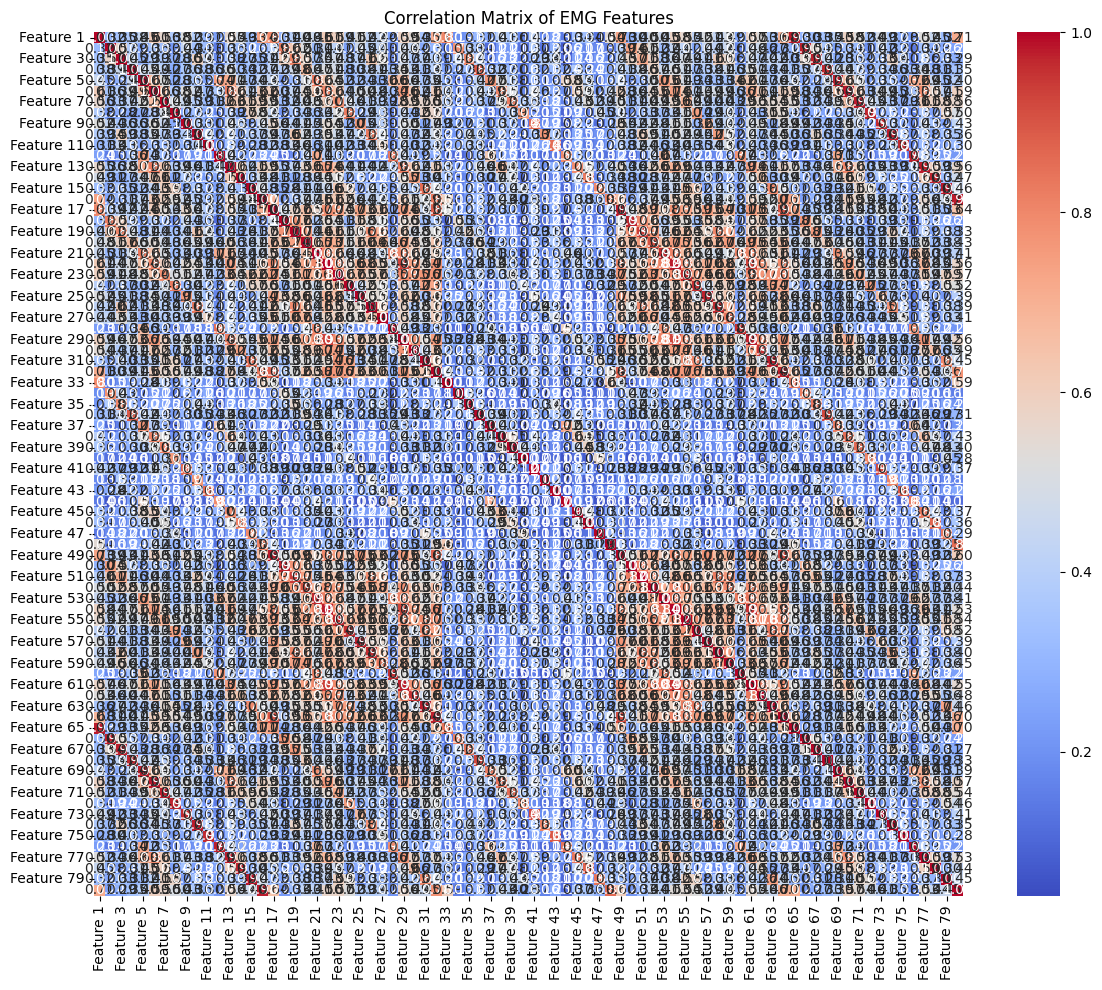

In [17]:
# Normalize the features using StandardScaler
scaler = StandardScaler()
EMG_train_normalized = scaler.fit_transform(EMG_train_extracted_features)
EMG_test_normalized = scaler.transform(EMG_test_extracted_features) 

# Use pandas DataFrame to improve readability
feature_names = [f"Feature {i+1}" for i in range(80)]  # Naming your 80 features
df_train = pd.DataFrame(EMG_train_normalized, columns=feature_names)

# Calculate the correlation matrix between features
correlation_matrix = df_train.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of EMG Features")
plt.tight_layout()
plt.show()

In [18]:
n_channels = EMG_train_windows.shape[2]

# Generate feature names for each type of feature
feature_names = (
    [f"Wilson Amplitude_{i+1}" for i in range(n_channels)] +
    [f"Waveform Length_{i+1}" for i in range(n_channels)] +
    [f"Log Variance_{i+1}" for i in range(n_channels)] +
    [f"Mean_{i+1}" for i in range(n_channels)] +
    [f"Std_{i+1}" for i in range(n_channels)]
)

print("Total number of features:", len(feature_names))

Total number of features: 80


#### Plot correlation between same features

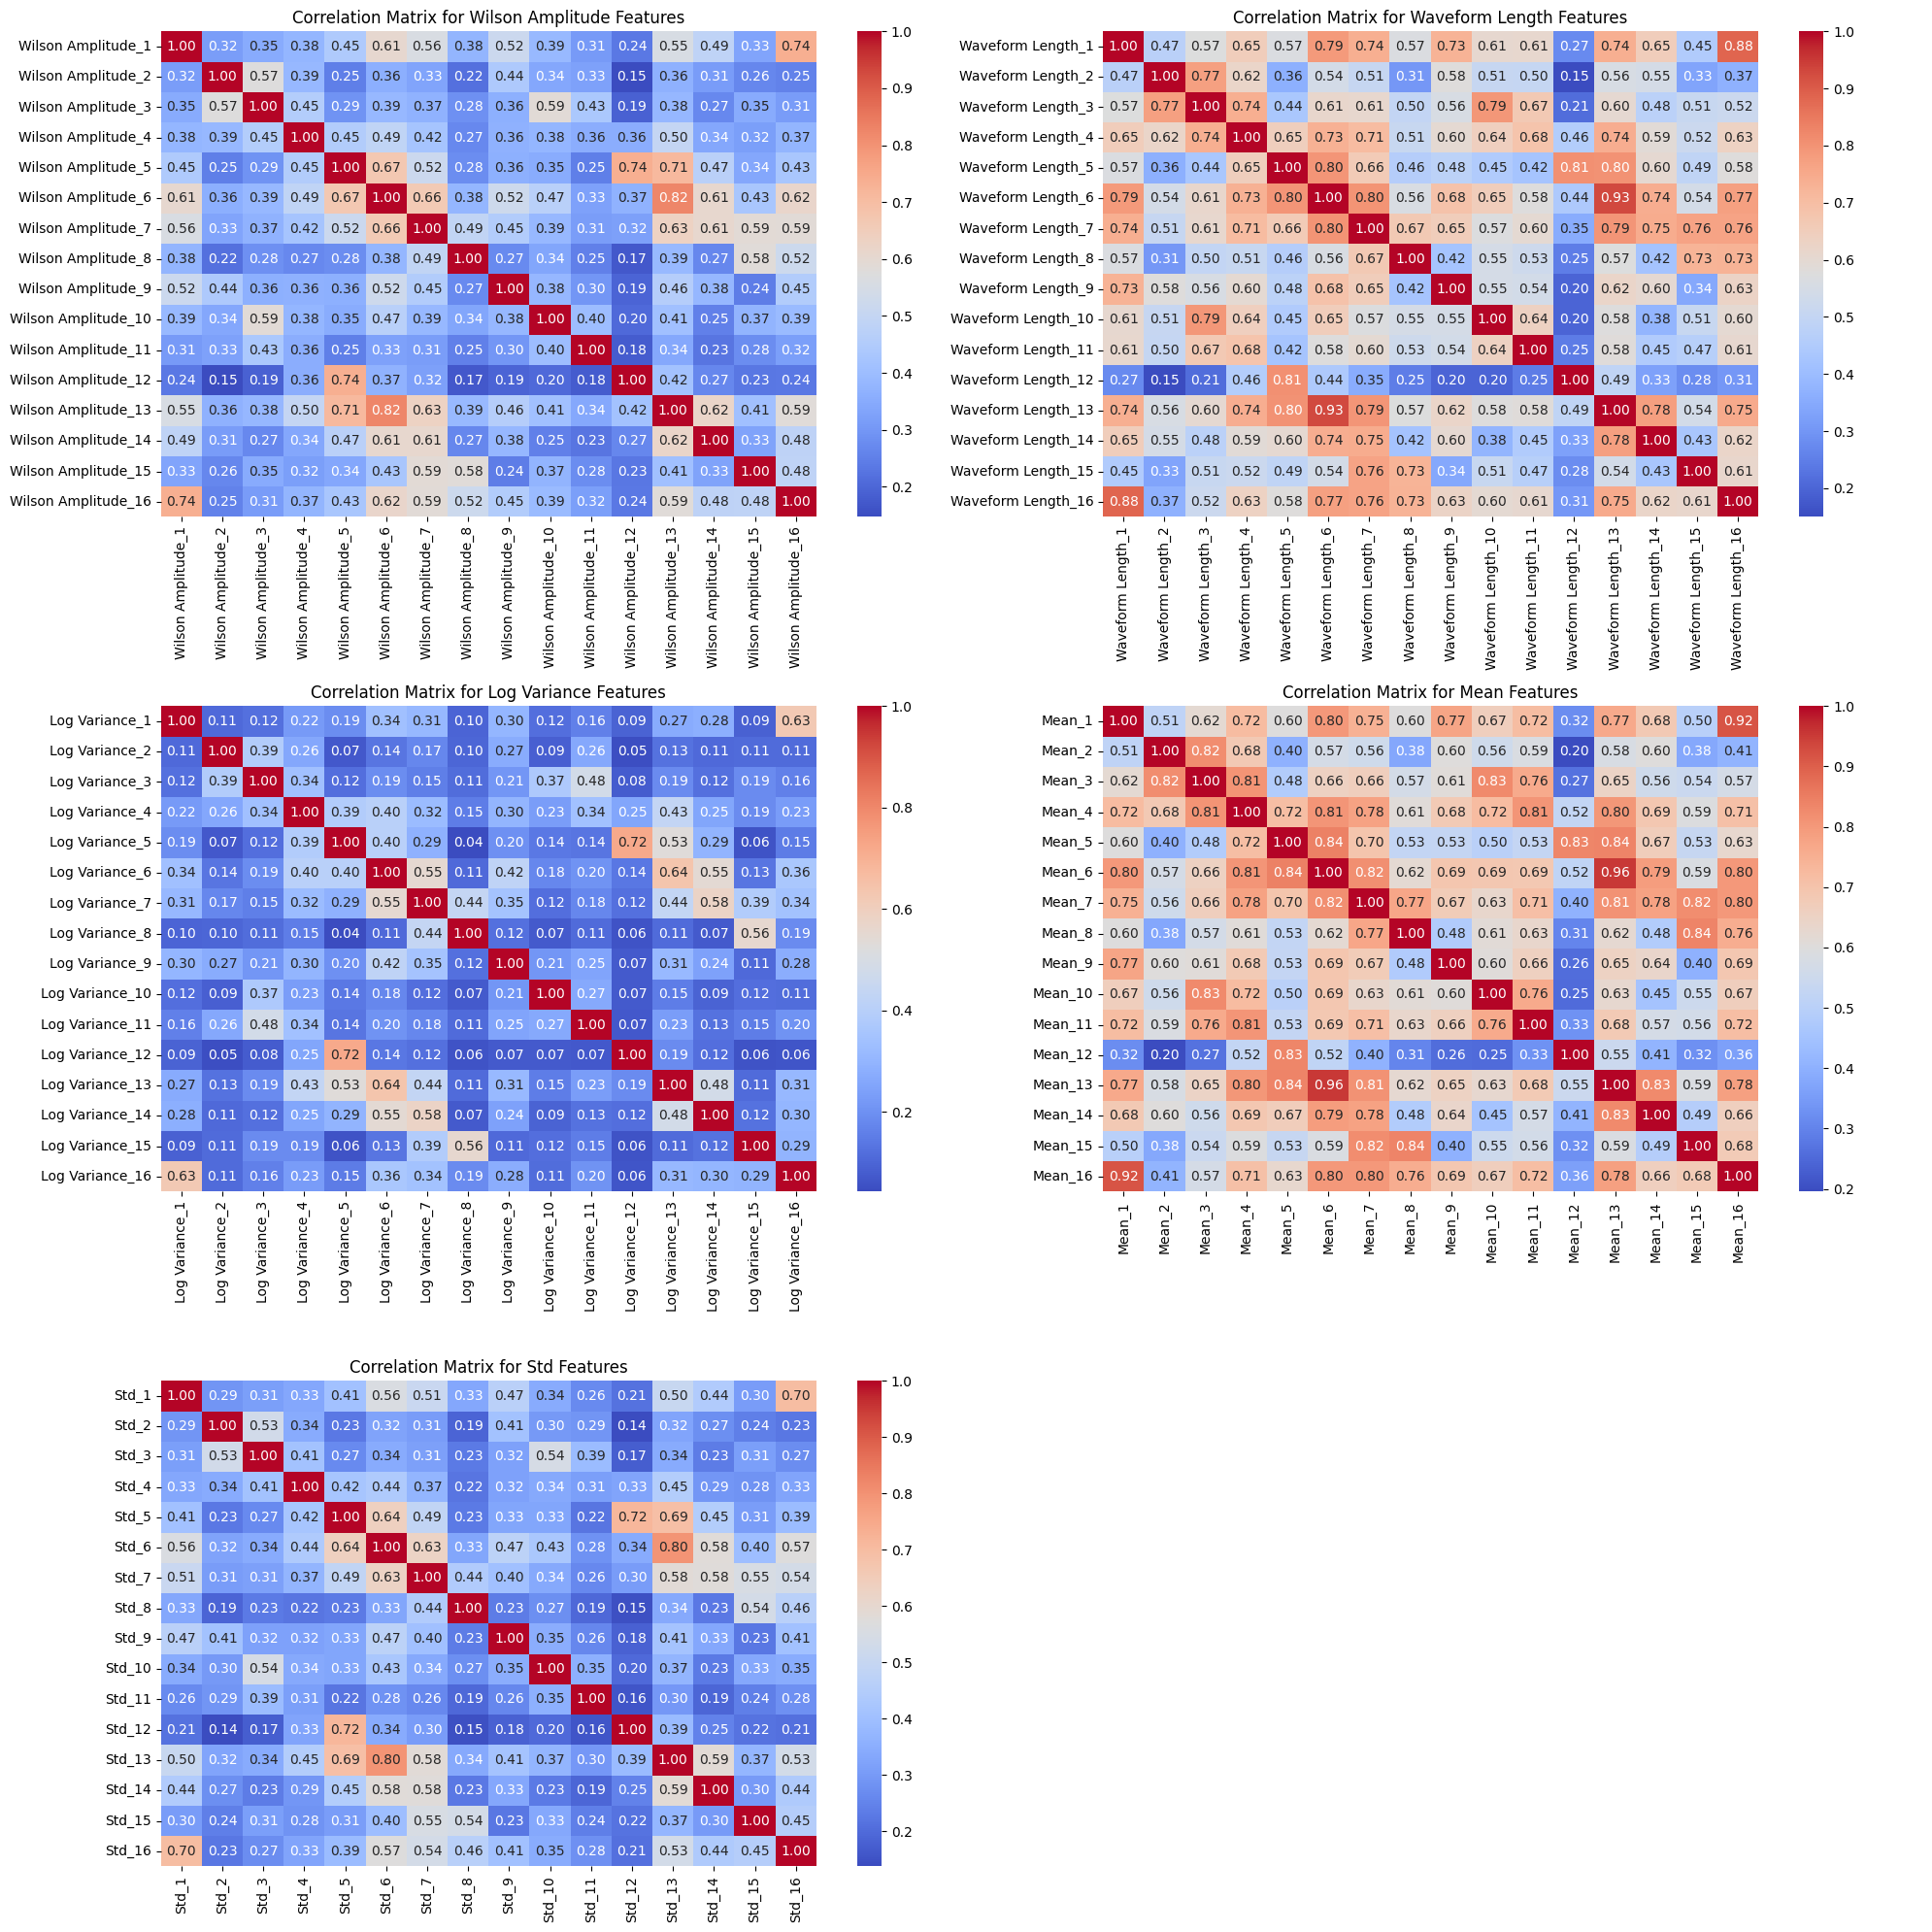

In [34]:
feature_groups = {
    "Wilson Amplitude": [name for name in feature_names if "Wilson Amplitude" in name],
    "Waveform Length": [name for name in feature_names if "Waveform Length" in name],
    "Log Variance": [name for name in feature_names if "Log Variance" in name],
    "Mean": [name for name in feature_names if "Mean" in name],
    "Std": [name for name in feature_names if "Std" in name],
}

# Normalize the features
scaler = StandardScaler()
EMG_train_normalized = scaler.fit_transform(EMG_train_extracted_features)

# Create a DataFrame for better readability
df_train = pd.DataFrame(EMG_train_normalized, columns=feature_names)

# Create a 2x3 grid of subplots (to accommodate 5 correlation matrices)
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each correlation matrix in the corresponding subplot
for i, (group_name, group_features) in enumerate(feature_groups.items()):
    ax = axes[i]  # Get the corresponding axis for the subplot
    sns.heatmap(df_train[group_features].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True, ax=ax)
    ax.set_title(f"Correlation Matrix for {group_name} Features")

# Hide the empty subplot (since we have only 5 groups)
axes[5].axis('off')

# Adjust layout to prevent overlap
plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.savefig('plots/corr_matrix1.png')
plt.tight_layout()
plt.show()

#### Plot correlation between different features in each channel

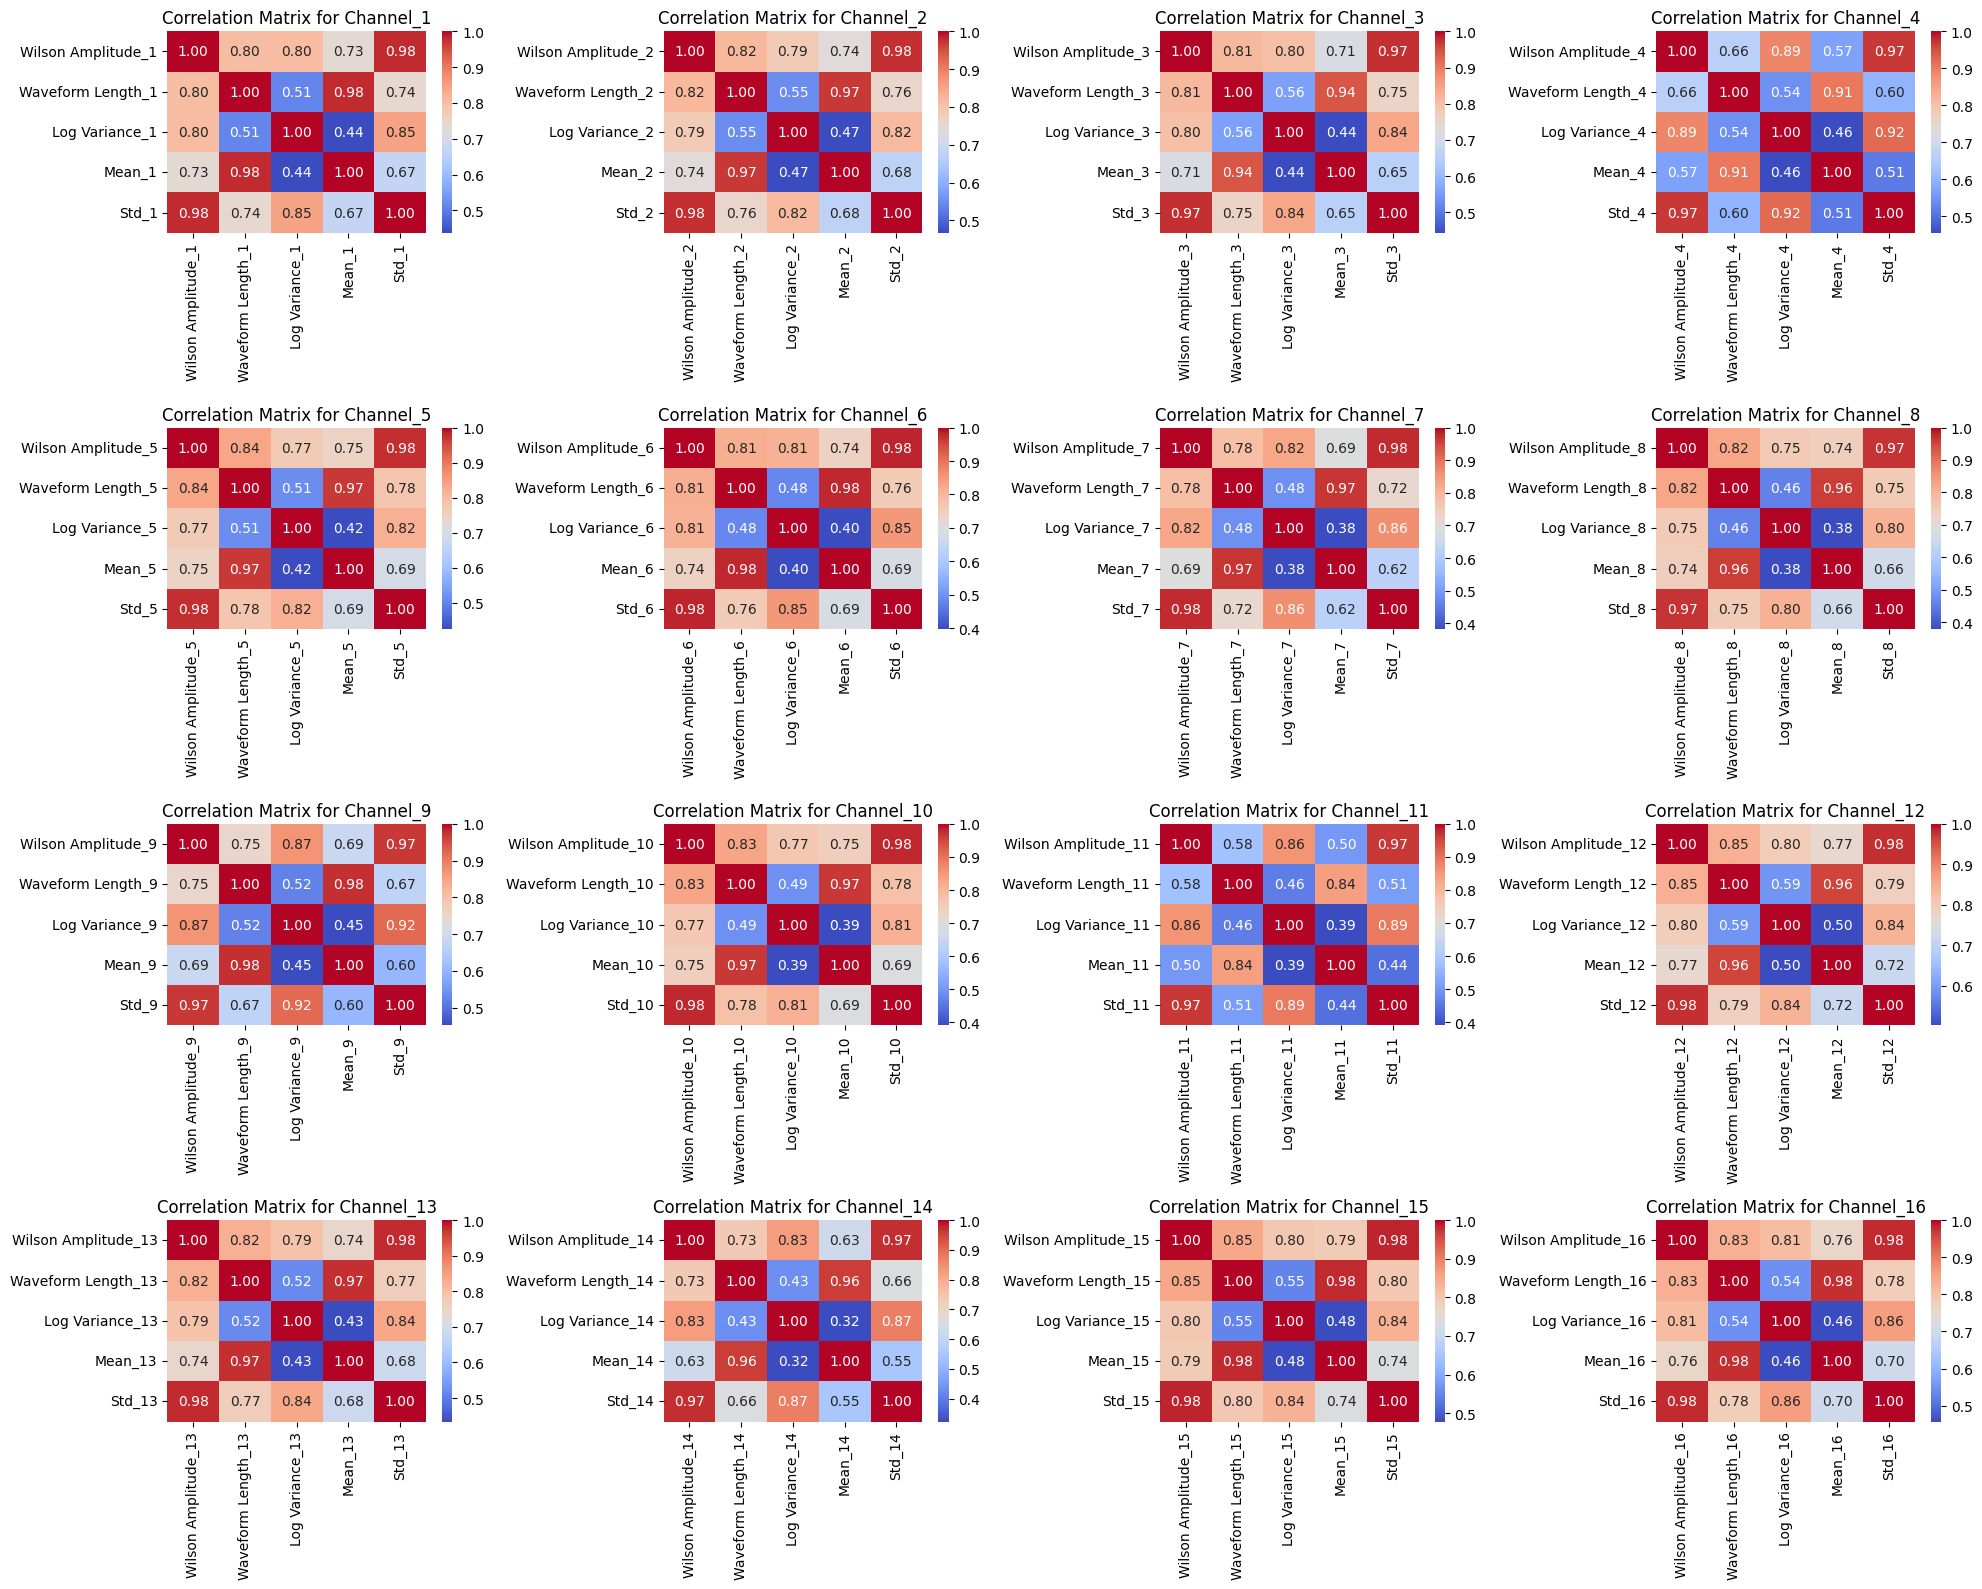

In [44]:
channels = [f"Channel_{i+1}" for i in range(n_channels)]
channel_feature_groups = {channel: [] for channel in channels}

for feature in feature_names:
    for i in range(n_channels):
        if re.search(rf"_{i+1}$", feature):  # Match the exact channel number at the end
            channel_feature_groups[f"Channel_{i+1}"].append(feature)

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each correlation matrix in the corresponding subplot
for i, (channel, features) in enumerate(channel_feature_groups.items()):
    ax = axes[i]  # Get the corresponding axis for the subplot
    sns.heatmap(df_train[features].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True, ax=ax)
    ax.set_title(f"Correlation Matrix for {channel}")

# Adjust layout to prevent overlap
plt.subplots_adjust(wspace=0.6, hspace=1.0)
plt.savefig('plots/corr_matrix2.png')
plt.tight_layout()
plt.show()

### 4 Perform regression

#### Random Forest regression

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(EMG_train_normalized, Labels_train_mean)

# Predict the labels on the test data
Labels_test_pred_rf = rf_model.predict(EMG_test_normalized)

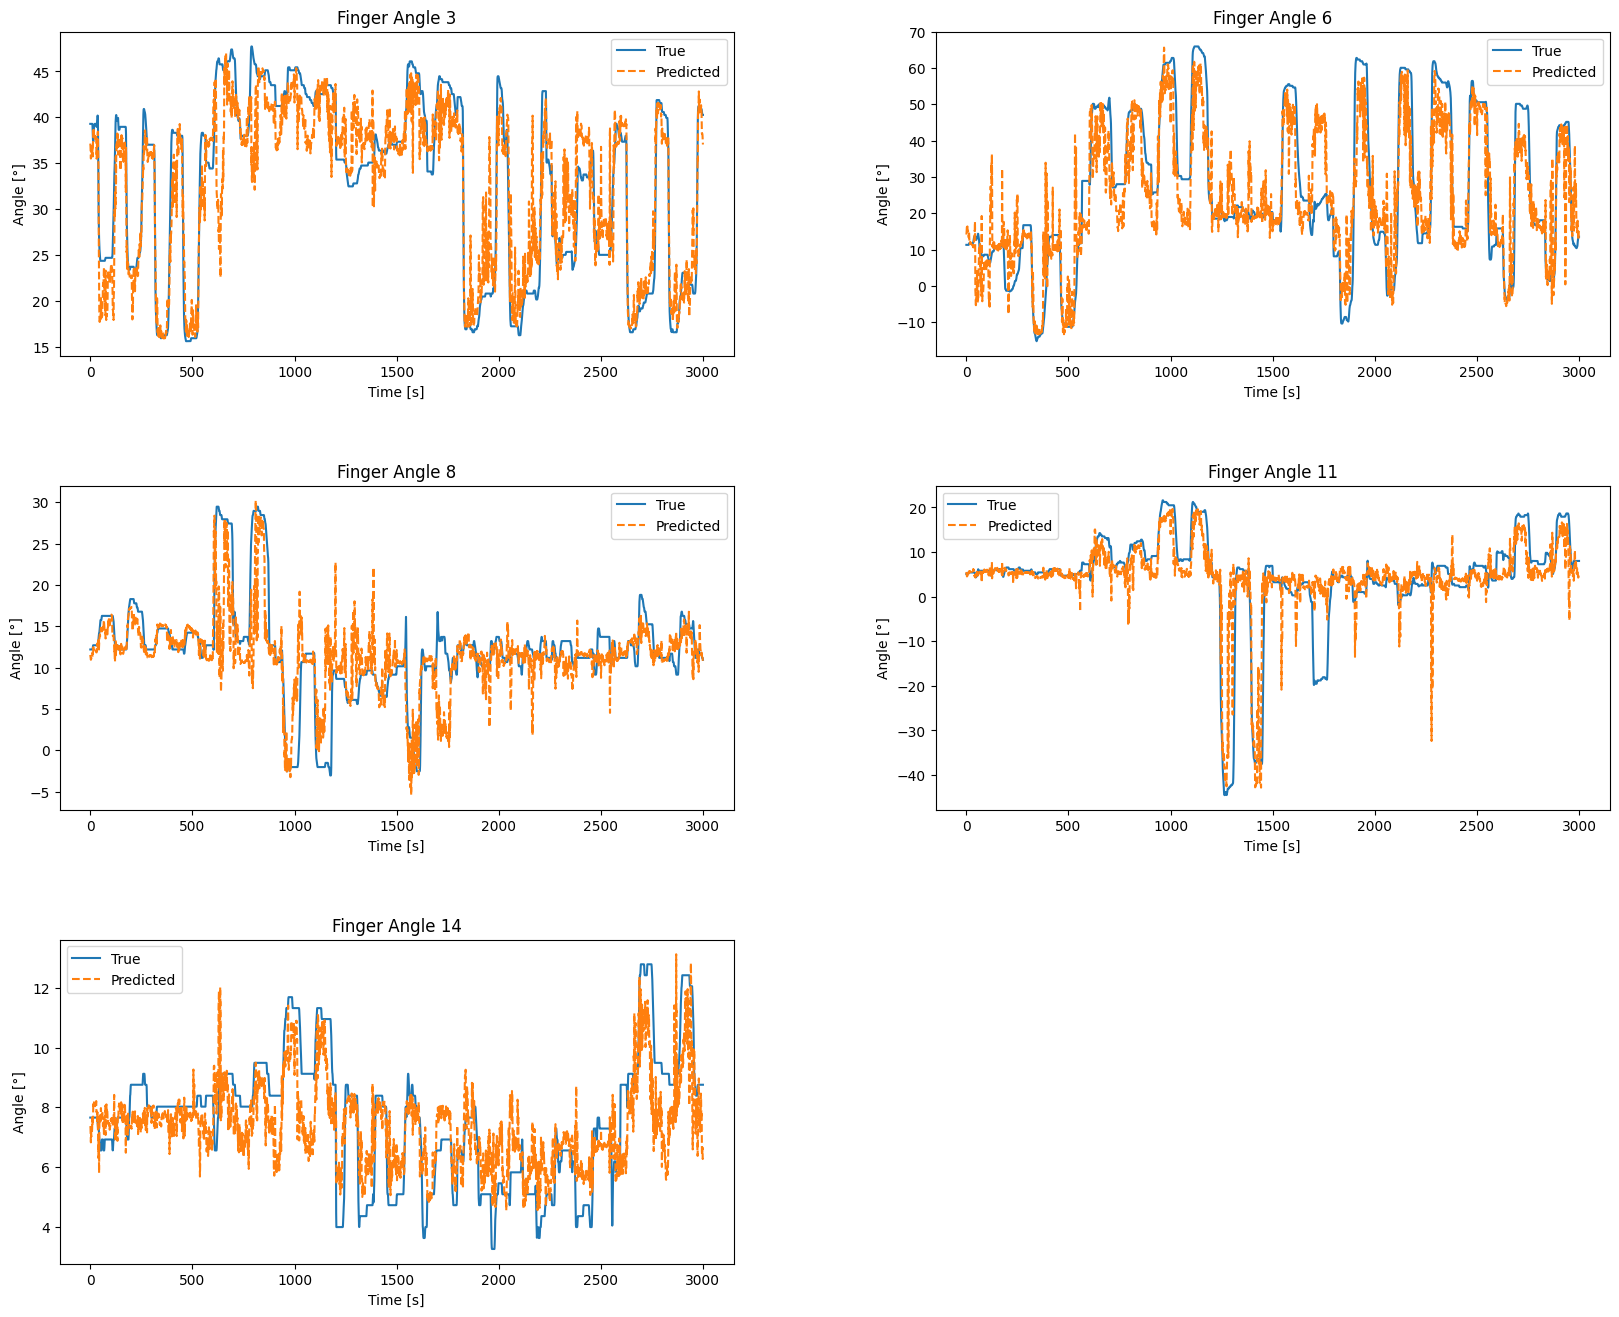

In [40]:
# Define the custom finger angle numbers
finger_angle_numbers = [3, 6, 8, 11, 14]

# Create a 2x3 grid of subplots (to accommodate 5 finger angles)
fig, axes = plt.subplots(3, 2, figsize=(20, 16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop over each finger angle and plot it in the corresponding subplot
for i, angle_num in enumerate(finger_angle_numbers):
    ax = axes[i]  # Get the corresponding axis for the subplot
    ax.plot(Labels_test_mean[:, i], label="True")  # True values for finger angle i
    ax.plot(Labels_test_pred_rf[:, i], linestyle="--", label="Predicted")  # Predicted values for finger angle i
    ax.legend()
    ax.set_title(f"Finger Angle {angle_num}")  # Use custom finger angle numbers
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Angle [°]")

# Hide the empty subplot (since we have only 5 angles)
axes[5].axis('off')
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig('plots/regression.png')

### 5 Evaluate the performance 

In [27]:
for i, angle_num in enumerate(finger_angle_numbers):

    y_true = Labels_test_mean[:, i]
    y_pred = Labels_test_pred_rf[:, i]
    
    # Compute metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Print the results
    print(f"Performance Metrics for Finger Angle {angle_num}:")
    print(f"  - Mean Squared Error (MSE): {mse:.4f}")
    print(f"  - Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  - R² Score: {r2:.4f}")

Performance Metrics for Finger Angle 3:
  - Mean Squared Error (MSE): 16.8043
  - Root Mean Squared Error (RMSE): 4.0993
  - Mean Absolute Error (MAE): 2.9425
  - R² Score: 0.8252
Performance Metrics for Finger Angle 6:
  - Mean Squared Error (MSE): 101.2363
  - Root Mean Squared Error (RMSE): 10.0616
  - Mean Absolute Error (MAE): 7.3191
  - R² Score: 0.7672
Performance Metrics for Finger Angle 8:
  - Mean Squared Error (MSE): 17.7225
  - Root Mean Squared Error (RMSE): 4.2098
  - Mean Absolute Error (MAE): 2.4417
  - R² Score: 0.4682
Performance Metrics for Finger Angle 11:
  - Mean Squared Error (MSE): 42.6300
  - Root Mean Squared Error (RMSE): 6.5292
  - Mean Absolute Error (MAE): 3.4528
  - R² Score: 0.6428
Performance Metrics for Finger Angle 14:
  - Mean Squared Error (MSE): 1.9108
  - Root Mean Squared Error (RMSE): 1.3823
  - Mean Absolute Error (MAE): 1.0907
  - R² Score: 0.5761


Joint angles are from 0 to 180 degrees, so an MSE of 36.06 suggests that the model's predictions are off by approximately 6 degrees 
(since the square root of 36.06 is about 6). Les predicted values suivent bien les true values mais il y a bcp d'overshoot 